In [1]:
from keras.models  import load_model
import keras.backend as K

import cPickle
import sys
sys.path.insert(0, '../../preprocess')
import vectorizer

import pandas as pd
import numpy as np

aspects = ['population', 'intervention', 'outcome']

Using TensorFlow backend.


In [2]:
vec = cPickle.load(open('../data/vectorizers/allfields_with_embedding_5000.p', 'rb'))

In [3]:
da = pd.read_csv('../data/files/decision_aids_filter.csv')

In [4]:
davec = cPickle.load(open('../data/vectorizers/decision_aids_vec_5000.p'))

In [45]:
model_population = load_model('../store/weights/separate/population_setup/MonOct1619:05:002017/loss.h5')
model_intervention = load_model('../store/weights/separate/intervention_setup/MonOct1619:05:002017/loss.h5')
model_outcome = load_model('../store/weights/separate/outcome_setup/MonOct1619:05:002017/loss.h5')
model = {'population' : model_population, 
         'intervention' : model_intervention, 
         'outcome' : model_outcome}

In [31]:
model_population = load_model('../store/weights/separate/population_setup/MonOct1621:08:272017/loss.h5')
model_intervention = load_model('../store/weights/separate/intervention_setup/MonOct1621:08:272017/loss.h5')
model_outcome = load_model('../store/weights/separate/outcome_setup/MonOct1621:08:272017/loss.h5')
model = {'population' : model_population, 
         'intervention' : model_intervention, 
         'outcome' : model_outcome}

In [46]:
import keras.backend as K

model_c1 = {}
for aspect in aspects :
    model_c1[aspect] = K.function(model[aspect].get_layer('pool').inputs + [K.learning_phase()], 
                          [model[aspect].get_layer('pool').get_output_at(0)])

In [47]:
pools = {}
for aspect in aspects :
    pools[aspect] = model_c1[aspect]([davec.X, 0])[0]

In [48]:
irange = vec.index['abstract']
X_abs = vec.X[irange[0]:irange[1]]
print(len(X_abs))
pools_cdsr = {}
for aspect in aspects :
    pools_cdsr[aspect] = []
    for i in range(int(np.floor(len(X_abs)/1000))) :
        pools_cdsr[aspect].append(model_c1[aspect]([X_abs[i*1000:(i+1)*1000,:], 0])[0])

41784


In [49]:
for aspect in aspects :
    pools_cdsr[aspect] = np.concatenate(pools_cdsr[aspect])

In [50]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [51]:
tsnes = {}
for aspect in aspects :
    pca = PCA()
    pca.fit(pools[aspect])
    pca.fit(np.concatenate([pools_cdsr[aspect], pools[aspect]], axis=0))
    tsnes[aspect] = pca

In [52]:
pcas = {}
for aspect in aspects :
    pcas[aspect] = tsnes[aspect].transform(pools[aspect])

In [53]:
im_map = {'breast cancer': 'BCT', 
          'healthy women at risk of breast cancer': 'BCS', 
          'type II diabetes': 'D',
          'menopausal women': 'MW',
          'pregnant women, previous C section': 'PWC',
          'pregnant women': 'PW',
          'healthy people, at risk colon cancer': 'CCS',
          'prostate cancer': 'PCT',
          'healthy men, contemplating risk of prostate cancer': 'PCS',
          'AF': 'AF',
          'healthy women at genetic risk of breast cancer': 'BCG'}

<h2>Objective Function :<br>
Population : (SA - SP) + (SA - VP) - (SA - CP)<br>
Similar for other aspects</h2>
<h3> Key to read objective function - S = Same, V = valid, C = Corrupt , A = Abstract, P = Pop, I = intervention, O = Outcome </h3>

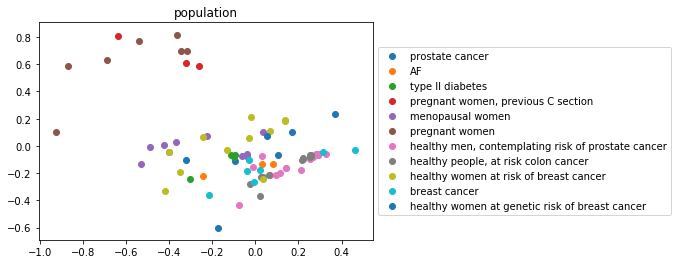

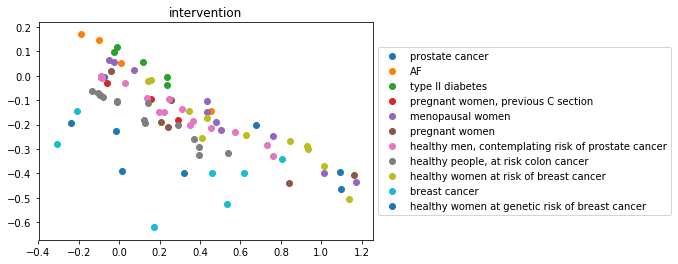

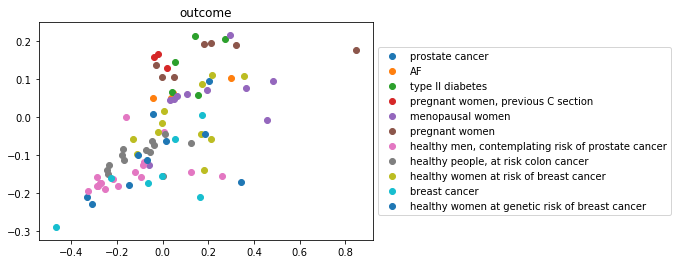

In [54]:
import matplotlib.pyplot as plt
for aspect in aspects :
    for key in im_map.keys() :
        idxs = da[da['IM_population'] == key].index
        plt.scatter(pcas[aspect][idxs, 0], pcas[aspect][idxs, 1], label=key)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(aspect)
    plt.show()

<h2>Objective Function :  <br>
Population : (SA - SP) + (SA - VP) - (SA - CP) - (SA - SI) - (SA - SO) <br>
Similar for other aspects
</h2>

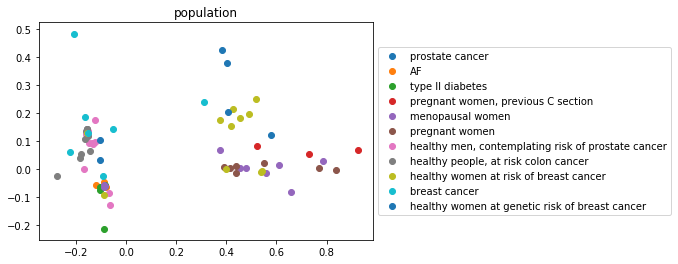

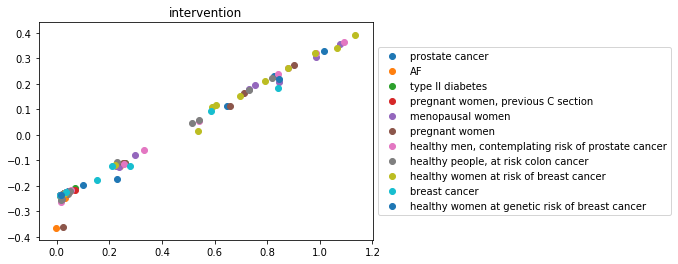

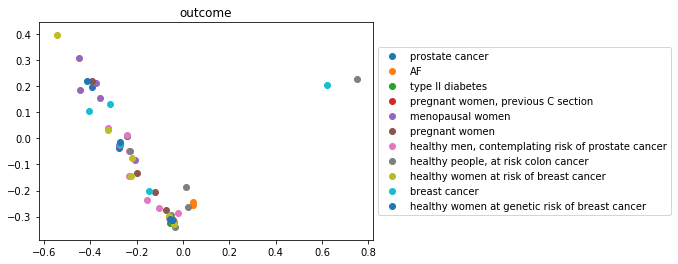

In [44]:
import matplotlib.pyplot as plt
for aspect in aspects :
    for key in im_map.keys() :
        idxs = da[da['IM_population'] == key].index
        plt.scatter(pcas[aspect][idxs, 0], pcas[aspect][idxs, 1], label=key)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(aspect)
    plt.show()